In [2]:
# This notebook requires py-pde in version 0.17.1 or later
# The package can be obtained from https://github.com/zwicker-group/py-pde
# Alternatively, it can be installed via pip or conda

import pde

# functools and _make_derivative2 are required for anisotropic laplacians
import functools
from pde.grids.operators.cartesian import _make_derivative2

# plotting functions
import matplotlib.pyplot as plt
import numpy as np

# Pole-to-pole oscillations
In the previous two notebooks, you learnt about the relevance of membrane interactions and how this can lead to gradients in the bulk (volume, cytosol) of a cell, and about the importance of nonlinearities in the interaction terms. Now, we will combine these two effects to reproduce a prominent example of dynamic protein pattern in living cells: the pole-to-pole oscillations of the MinCDE system in _E. coli_.

The MinCDE system regulates the placement of the division site in _E. coli_ bacteria. More precisely, the MinC protein inhibits the formation of the Z-ring. By oscillating between the poles, the MinC proteins is mainly located at the cell poles, and rarely at the cell center. Thus, the inhibitory effect is weakest at the cell center, such that the Z-ring forms just there, resulting in symmetric cell division.

If you are unfamiliar with the system, have a look at https://static-movie-usa.glencoesoftware.com/mp4/10.7554/384/2cd69eb620315bb0a04c26d92e1300548d3bca6d/elife-03949-media1.mp4 (from Zieske and Schwille, eLife, 2014, elifesciences.org/articles/03949). The video shows protein concentrations in _E. coli_ cells of varying aspect ratio. In nature, _E. coli_ have an aspect ratio of about $5$ just before cell division, for which the proteins oscillate between the two cell poles (e.g., column 1, row 4 in the linked movie). In the following, we will aim to reproduce these oscillations in simulations.

The Min protein oscillations require only the MinD and MinE proteins; the MinC protein is needed for downstream regulation of the Z-ring, but not to maintain the patterning process. Thus, we will only use the former two proteins in the following.

The Min proteins interact with each other as follows:
 - MinD exists in three states: bound to the membrane ($c_d$, `c_d`), as well as in the cytosol bound to ATP ($c_{DT}$, `c_DT`) and to ADP ($c_{DD}$, `c_DD`).
 - MinE is present in the cytosol ($c_E$, `c_E`).
 - On the membrane, MinD and MinE can form a complex ($c_{de}$, `c_de`).


 - MinD-ATP binds to the membrane at a rate $k_D$. In addition, it is recruited to the membrane by other membrane-bound MinD proteins at a rate $k_{dD}$.
 - MinE is recruited by MinD to the membrane at a rate $k_{dE}$. Whenever a MinE protein is recruited, it forms a complex together with the MinD protein ($c_{de}$).
 - MinDE complexes detach from the membrane at a rate $k_{de}$. Upon detachment, the complex breaks up, releasing a MinE protein and a MinD-ADP protein into the cytosol. Note that the MinD-ADP proteins can not bind to the membrane (see above).
 - Finally, in the cytosol, MinD-ADP is converted to MinD-ATP at a rate $k_{nucEx}$, corresponding to nucleotide exchange.

The corresponding partial differential equations read:
$$
\partial_t c_{DD} = D_{cytD} \cdot \nabla^2 c_{DD} - k_{nucEx} \cdot c_{DD} \\
\partial_t c_{DT} = D_{cytD} \cdot \nabla^2 c_{DT} + k_{nucEx} \cdot c_{DD} \\
\partial_t c_{E} = D_{cytE} \cdot \nabla^2 c_{E} \\
\partial_t c_{d} = D_{mem} \cdot \nabla_m^2 c_{d} + c_{DT} \cdot ( k_{D} + k_{dD} \cdot c_d) -  k_{dE} \cdot c_E \cdot c_d \\
\partial_t c_{de} = D_{mem} \cdot \nabla_m^2 c_{de} +  k_{dE} \cdot c_E \cdot c_d - k_{de} \cdot c_{de}  \, ,
$$
with reactive boundary conditions for the cytosolic quantities
$$
D_{cytD} \, \nabla_n c_{DD} = k_{de} \cdot c_{de} \\
D_{cytD} \, \nabla_n c_{DT} = - c_{DT} \cdot ( k_{D} + k_{dD} \cdot c_d) \\
D_{cytE} \, \nabla_n c_{E} = k_{de} \cdot c_{de} - k_{dE} \cdot c_E \cdot c_d \, .
$$

As before, $\nabla_n$ denotes the gradient perpendicular to the membrane, whereas $\nabla_m^2$ is the diffusion operator along the membrane.

## Part 1: Analysing the problem heuristically

### Problem 1: Nonlinearities
Note down all the nonlinear terms in the PDEs above.

### Problem 2: Intuitive analysis
Consider the states where MinD and MinE proteins are homogeneously distributed
 - both on the membrane (only $c_{de}$ is non-zero),
 - on the membrane (MinD, $c_d \neq 0$) and in the cytosol (MinE, $c_E \neq 0$, all other quantities are zero),
 - both in the cytosol (ATP-bound), i.e., $c_{DD} = c_d = c_{de} = 0$, and the other two quantities are non-zero.
 
For each of these cases, describe (in words) the protein dynamics in this state.

_Hint: use phrases like "MinD proteins bind to the membrane", "additional MinD is recruited to the membrane", "MinDE complexes detach from the membrane", etc._

## Part 2: Testing the system numerically
### Problem 3
The system involves reactive boundary conditions, diffusion on curved membranes, and is extremely sensitive to protein concentration numbers. This all makes a numeric implementation rather tedious, and requires some tinkering at several points. Walk through the following code carefully, and make a list of the steps and pitfalls required when translating a formal set of equations into real code. You are also required to complete (i.e., fill in blanks) the expressions representing the PDEs.

#### Geometry, grid, and concentrations:
The Min system is extremely sensitive to variations in average protein concentrations. This means that pole-to-pole oscillations can be observed, for example, at a specific protein concentration $c_E^*$, but for slightly varied concentrations ($\pm 10 \%$) the oscillations break down. This poses a major problem for numerical implementation: since the grid is discrete and not continuous, it is not straightforward to define a concentration that respects the conservation of mass and at the same time does not alter the PDEs. In general, this issue can be resolved by carefully rescaling all parameters and quantities based on the mesh resolution. For simplicity, however, we cheat here and use a geometry that happens to have the correct scaling (i.e., one where the grid cells have resolution 1).

In nature, _E. coli_ cells are $5 \mu m$ long and $1 \mu m$ wide. To observe a pattern, we need about five grid cells (preferably much more) in each direction. Instead of the "natural" geometry of the cells, we therefore blow up the geometry by a factor 5, so that we can have sufficiently high resolution of the grid cells while keeping the resolution parameter at 1.

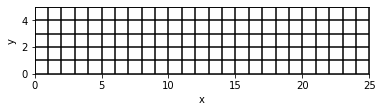

In [4]:
# Define the geometry of the system.
# We use a regular grid (rectangle) with a specified width (x-direction) and height (y-direction).

width = 25
height = 5
resolution = 1

# pde.CartesianGrid() creates a grid object (mesh) specified by the rectangle corners and a sampling resolution for both axes.
grid = pde.CartesianGrid(
    [[0, width], [0, height]],
    [int(resolution*i) for i in [width, height]]
)
grid.plot();

#### Membrane masking:
To simulate the membrane dynamics, `py-pde` requires a mask, like in the source-degradation exercise. Now, however, the situation is more complex, since the membrane now encloses the cell (instead of being just one horizontal line). On the horizontal cell membranes, there will be only diffuxion in x-direction, whereas on the vertical membrane there is diffusion in y-direction. To account for this, we define two separate masks, `mask_x` and `mask_y`.

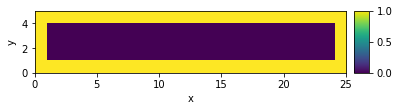

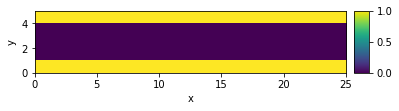

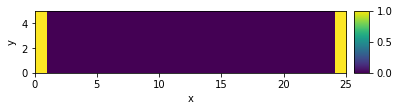

In [5]:
membrane_mask = pde.ScalarField(grid, dtype=float)
membrane_mask.data[:, 0] = 1.0
membrane_mask.data[:, -1] = 1.0
membrane_mask.data[0,:] = 1.0
membrane_mask.data[-1,:] = 1.0

mask_x, mask_y = [pde.ScalarField(grid, dtype=float) for _ in range(2)]
mask_x.data[:,0] = 1.0
mask_x.data[:,-1] = 1.0
mask_y.data[0,:] = 1.0
mask_y.data[-1,:] = 1.0


membrane_mask.plot();
mask_x.plot();
mask_y.plot();

In [6]:
# Set up laplace operator in x direction only
make_laplace_x = functools.partial(_make_derivative2, axis=0)
pde.CartesianGrid.register_operator('laplace_x', make_laplace_x)

# Set up laplace operator in y direction only
make_laplace_y = functools.partial(_make_derivative2, axis=1)
pde.CartesianGrid.register_operator('laplace_y', make_laplace_y)


#### Defining the system:
Now we can translate the PDEs into code. For the parameters, we use values obtained in Halatek and Frey, Cell, 2012 (cell.com/cell-reports/fulltext/S2211-1247(12)00118-0). These are in parts determined experimentally, and in parts via numeric parameter sweeps.

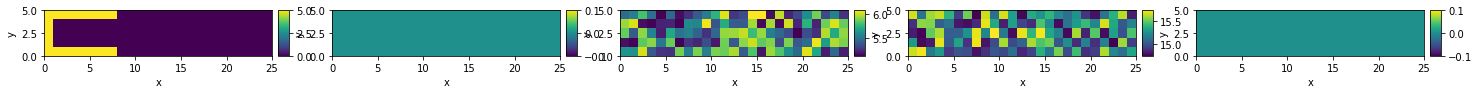

100%|██████████████████████████████████████████████████████████████████████████| 2000.0/2000.0 [02:26<00:00, 13.62it/s]


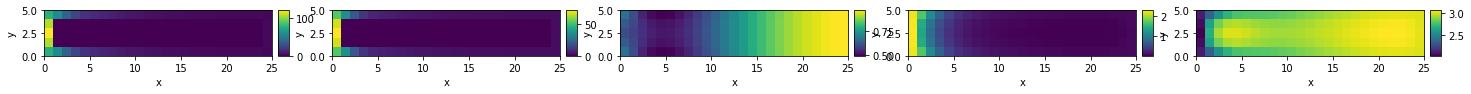

In [7]:
# Parameters
D_cytD = 16
D_cytE = 10
D_mem = 0.01

k_nucEx = 6

k_D = 0.1
k_dD = 0.1
k_dE = 0.4
k_de = 0.4

nD = 2000
nE = 700

# Equations with boundary conditions
expr = {'c_d' : f'(laplace_x(c_d ) * maskX + laplace_y(c_d ) * maskY) * {D_mem} + ' +  # Diffusion
                f'mask * (c_DT * ({k_D} + {k_dD} * c_d) - {k_dE} * c_E * c_d)',        # Reaction
        
        'c_de': f'                  ## BLANK ##                       * {D_mem} + ' +  # Diffusion
                f'mask * ({k_dE} * c_E * c_d - {k_de} * c_de)',                        # Reaction

        
        'c_E': f'laplace(c_E) * {D_cytE} + ' +                                         # Diffusion
               f'mask * ({k_de} * c_de - {k_dE} * c_E * c_d)',                         # Boundary
        
        'c_DD': f'laplace(c_DD) * {D_cytD} ' +                                         # Diffusion
                f'- {k_nucEx} * c_DD + ' +                                             # Reactions
                f'mask * ({k_de} * c_de)',                                             # Boundary
        
        'c_DT': f'## BLANK ## ' +                                                      # Diffusion
                f'+ ## BLANK ## + ' +                                                  # Reactions
                f'mask * (-c_DT * ({k_D} + {k_dD} * c_d))'}                            # Boundary

# Set the initial values for all fields:
# To keep deviations from the total mass minimal, we randomize only two fields.
c_d = pde.ScalarField.random_uniform(grid) * 0.0
c_de = pde.ScalarField.random_uniform(grid) * 0.0
c_E = pde.ScalarField.random_uniform(grid) * 1.0 - 0.5
c_DD = pde.ScalarField.random_uniform(grid) * 1.0 - 0.5
c_DT = pde.ScalarField.random_uniform(grid) * 0.0

# Introduce an initial asymmetry to speed up the simulations:
## To ensure mass conservation later on, we need to introduce an auxilary variable.
nodeCount = grid.shape[0] * grid.shape[1]

## Now we place some MinD on the left side of the membrane
c_d.data[:8,:] = 5
c_d.data = c_d.data * membrane_mask

## To ensure mass conservation, we need to remove the MinD proteins that we just placed
## on the membrane from the cytosol, and evenly distribute the remaining MinD in the 
## MinD-ADP state.
c_DD.data[:,:] += (nD - sum(sum(c_d.data))) / nodeCount
c_E.data[:,:] += nE / nodeCount


# Now solve the system as usual:
eq = pde.PDE(expr, consts={'mask': membrane_mask, 'maskX': mask_x, 'maskY': mask_y})

field = pde.FieldCollection([c_d, c_de, c_E, c_DD, c_DT])
field.plot();

storage = pde.MemoryStorage()

res = eq.solve(field, t_range=2000, tracker=[storage.tracker(1), "progress"])
res.plot();

## Part 3: Evaluation

### Problem 4: Basic consistency checks
To make sure that there are no typos in our code, it is good practice to make consitency checks on the simulation results. These consist of calculating/plotting quantities from the data that we can also compute analytically: if the results don't match the expectations, then something went wrong.

A simple consistency check for mass-conserving systems is the conservation of mass. Plot the _total_ MinD mass and MinE mass over time, and check whether the mass is conserved. Explain observed deviations from mass conservation.

_Hint: the total mass is computed by adding the concentrations of all corresponding fields and summing over all vertices._

_Hint: note that the concentration of MinDE complexes contributes to the MinD mass as well as to the MinE mass._

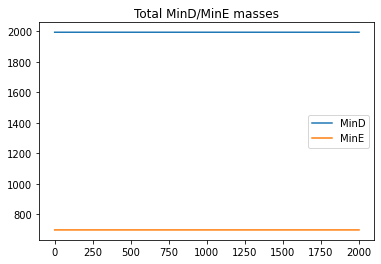

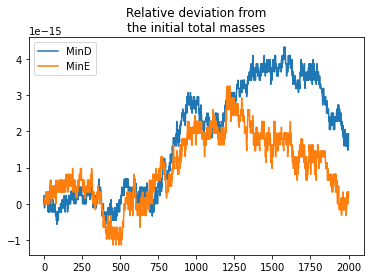

In [66]:
times = np.arange(len(storage.data))

# This is a check whether the total mass is conserved. The entries in each sublist should remain constant (within factor 0.001).
# The first row is the total MinE mass (c_de + c_E = nE), the second row is the total MinD mass (c_d + c_de + c_DD + c_DT = nD).
MinD_mass = np.array([sum([sum(sum(_)) for _ in [storage.data[t][i] for i in  [0,1,3,4]]]) for t in times])
MinE_mass = np.array([sum([## BLANK ## for _ in [## BLANK ##]]) for t in times])

plt.plot(times, MinD_mass, label="MinD")
plt.plot(times, MinE_mass, label="MinE")
plt.legend()
plt.title("Total MinD/MinE masses")
plt.show()

plt.plot(times, (MinD_mass - MinD_mass[0])/nD, label="MinD")
plt.plot(times, (MinE_mass - MinE_mass[0])/nE, label="MinE")
plt.legend()
plt.title("Relative deviation from\nthe initial total masses")
plt.show()


### Problem 4: Concentration plot
To visualize our results and be able to interpret them, make a plot of the MinD concentration on the membrane (`c_d`) over time.

_Hint: choose a specific pixel, and extract the concentration at this pixel over time._

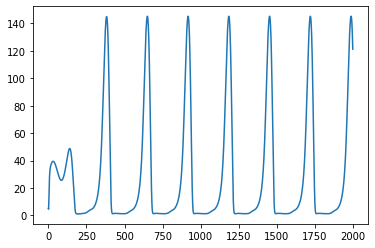

In [67]:
times = ## BLANK ##
MinD_concentration = ## BLANK ##
plt.plot(times, MinD_concentration)
plt.show()

### Problem 5: Kymograph
A very suitable representation of the simulation data is a kymograph. In a kymograph, one axis represents time, and the other axis represents a 1D slice through the system. Thus, the kymograph shows a concentration along this slice over time.

Make a kymograph of the MinD-ADP concentration along the horizontal center axis of the system.

_Hint: due to the specific choice of initial conditions, the first few time steps distort the color range. Consider excluding the first 5 time steps in the kymograph for better visibility._

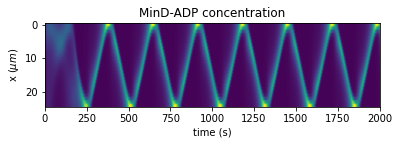

In [75]:
kymo = []
for i in range(len(storage.data)):
    kymo.append(## BLANK ##)
kymo = np.array(kymo)



plt.imshow(kymo.T, aspect=20);
plt.title("MinD-ADP concentration")
plt.xlabel("time (s)")
plt.ylabel("x $(\mu m)$")
plt.show();

Make kymographs for the MinD-ATP concentration, the MinE concentration, as well as the two membrane concentrations.

_Hint: the membrane concentrations should be evaluated on the membrane, not at a central slize._

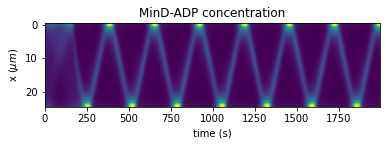

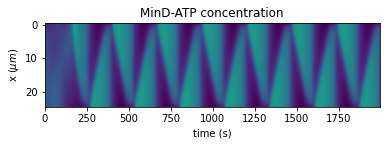

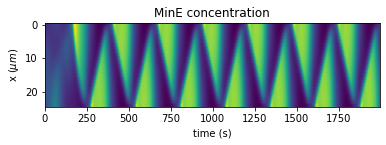

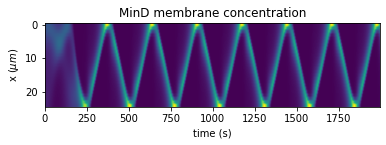

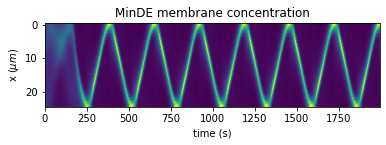

In [86]:
def full_kymograph(data, aspect_ratio_rescaling = 1):

    lst = [("MinD-ADP", 3, 2), ("MinD-ATP", 4, 2), ("MinE", 2, 2), ("MinD membrane", 0, 0), ("MinDE membrane", 1, 0)]

    for lbl, index, pos in lst:
        kymo = []
        for i in range(len(data)):
            ## BLANK ##
        kymo = np.array(kymo)



        plt.imshow(kymo.T, aspect=20/aspect_ratio_rescaling);
        plt.title(lbl + " concentration")
        plt.xlabel("time (s)")
        plt.ylabel("x $(\mu m)$")
        plt.show();

full_kymograph(storage.data)

### Problem 6: Length variations
As you can see in the video of _E. coli_ cells linked above, different oscillation "modes" can be observed for different cell aspect ratios: for short cells, the desired pole-to-pole oscillations are obtained, but for long cells, multiple oscillations are present simultaneously. In the following, we will reproduce these observations.

Discuss your observations.

In [95]:
def simulate_with_different_length(rescale_factor):

    width = 25 * rescale_factor
    height = 5
    resolution = 1

    
    grid = pde.CartesianGrid(
        [[0, width], [0, height]],
        [int(resolution*i) for i in [width, height]]
    )
    grid.plot();


    membrane_mask = pde.ScalarField(grid, dtype=float)
    membrane_mask.data[:, 0] = 1.0
    membrane_mask.data[:, -1] = 1.0
    membrane_mask.data[0,:] = 1.0
    membrane_mask.data[-1,:] = 1.0

    mask_x, mask_y = [pde.ScalarField(grid, dtype=float) for _ in range(2)]
    mask_x.data[:,0] = 1.0
    mask_x.data[:,-1] = 1.0
    mask_y.data[0,:] = 1.0
    mask_y.data[-1,:] = 1.0

    # Parameters
    D_cytD = 16
    D_cytE = 10
    D_mem = 0.01

    k_nucEx = 6

    k_D = 0.1
    k_dD = 0.1
    k_dE = 0.4
    k_de = 0.4

    nD = 2000 * rescale_factor
    nE = 700 * rescale_factor

    expr = {'c_d' : f'(laplace_x(c_d ) * maskX + laplace_y(c_d ) * maskY) * {D_mem} + ' +  # Diffusion
                    f'mask * (c_DT * ({k_D} + {k_dD} * c_d) - {k_dE} * c_E * c_d)',        # Reaction
            'c_de': f'(laplace_x(c_de) * maskX + laplace_y(c_de) * maskY) * {D_mem} + ' +  # Diffusion
                    f'mask * ({k_dE} * c_E * c_d - {k_de} * c_de)',                        # Reaction

            'c_E': f'laplace(c_E) * {D_cytE} + ' +                                         # Diffusion
                   f'mask * ({k_de} * c_de - {k_dE} * c_E * c_d)',                         # Boundary
            'c_DD': f'laplace(c_DD) * {D_cytD} - {k_nucEx} * c_DD + ' +                    # Diffusion
                    f'mask * ({k_de} * c_de)',                                             # Boundary
            'c_DT': f'laplace(c_DT) * {D_cytD} + {k_nucEx} * c_DD + ' +                    # Diffusion
                    f'mask * (-c_DT * ({k_D} + {k_dD} * c_d))'}                            # Boundary

    c_d = pde.ScalarField.random_uniform(grid) * 0.0
    c_de = pde.ScalarField.random_uniform(grid) * 0.0
    c_E = pde.ScalarField.random_uniform(grid) * 1.0 - 0.5
    c_DD = pde.ScalarField.random_uniform(grid) * 1.0 - 0.5
    c_DT = pde.ScalarField.random_uniform(grid) * 0.0

    nodeCount = grid.shape[0] * grid.shape[1]
    c_d.data[:8,:] = 5
    c_d.data = c_d.data * membrane_mask
    c_DD.data[:,:] += (nD - sum(sum(c_d.data))) / nodeCount
    c_E.data[:,:] += nE / nodeCount

    eq = pde.PDE(expr, consts={'mask': membrane_mask, 'maskX': mask_x, 'maskY': mask_y})
    field = pde.FieldCollection([c_d, c_de, c_E, c_DD, c_DT])

    storage = pde.MemoryStorage()

    res = eq.solve(field, t_range=2000, tracker=[storage.tracker(1)])
    res.plot();
    return storage

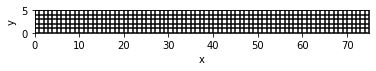

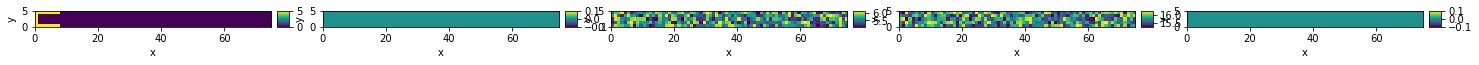

100%|██████████████████████████████████████████████████████████████████████████| 2000.0/2000.0 [02:49<00:00, 11.82it/s]


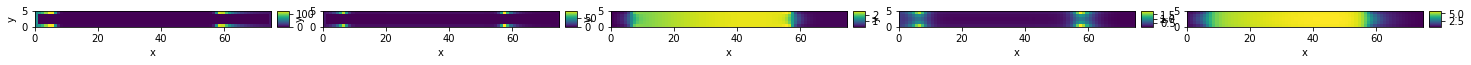

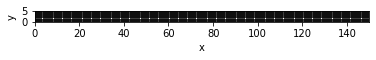

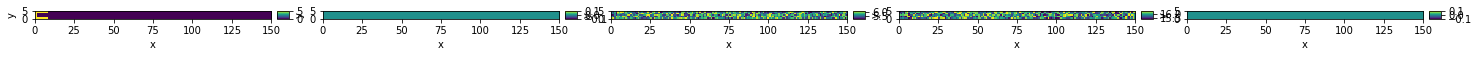

100%|██████████████████████████████████████████████████████████████████████████| 2000.0/2000.0 [03:17<00:00, 10.14it/s]


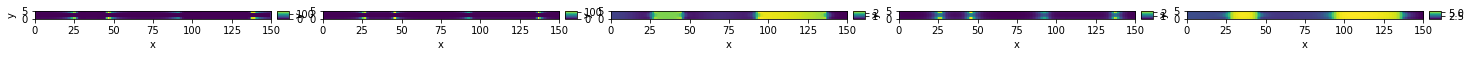

In [89]:
s3 = simulate_with_different_length(3.)
s6 = simulate_with_different_length(6.)

3-fold length


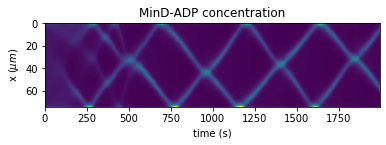

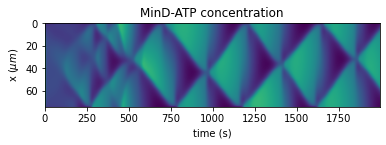

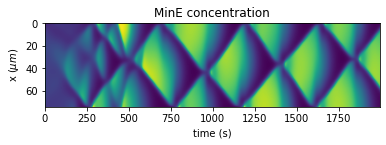

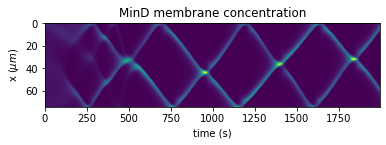

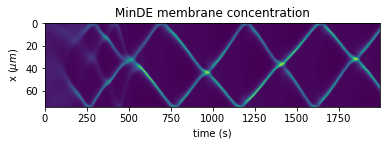

6-fold length


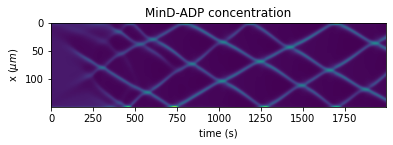

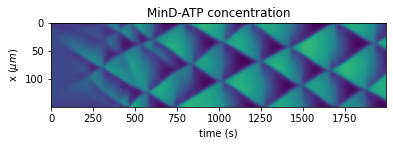

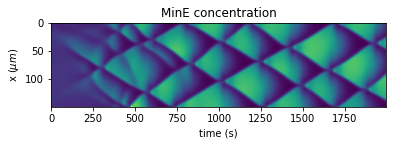

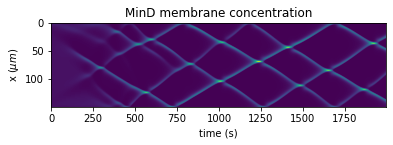

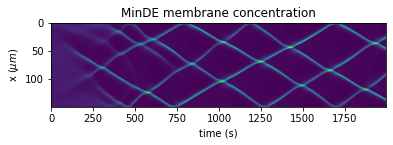

In [94]:
for s, i in [(s3, 3), (s6, 6)]:
    print(f"{i}-fold length")
    full_kymograph(s.data, aspect_ratio_rescaling=i)